# Predictive Model - Identification of Terrorists Groups

## A) Purpose

The main purpose of this project is to build a predictive model in order to classify probable perpetrators of terrorist attacks, based on its characteristics, using supervised machine learning algorithm - Random Forest.  

In a first step, we must exclude from the dataset all the entries without known perpetrators in the interest of training the model. Additionally, we create a function that lists a range of the most probable perpetrators whenever the level of certainty of the prediction is low.

Later, we make use of the trained model to try to verify the suitability of the unknown attacks with the characteristics of the known ones. If the level of certainty is unsatisfactory, we segregate the entries and run a K-Means unsupervised machine learning algorithm with the objective of aggregating these ones, trying to find patterns that can support further investigation.

 


## B) DATA

We rely on the Global Terrorism Database (GTD), which can be acessed [here](https://www.kaggle.com/START-UMD/gtd/download). 

"National Consortium for the Study of Terrorism and Responses to Terrorism (START), University of Maryland. (2018). The Global Terrorism Database (GTD) [Data file]. Retrieved from https://www.start.umd.edu/gtd"
b. You agree to acknowledge any copyrightable materials with a copyright notice “Copyright University of Maryland 2018.”

GTD is an open-source database including information on terrorist attacks around the world from 1970 through 2017. The GTD includes systematic data on terrorist incidents that have occurred during this time period and now includes more than 180,000 attacks. The database is maintained by researchers at the National Consortium for the Study of Terrorism and Responses to Terrorism (START), headquartered at the University of Maryland.

#### GTD Definition of Terrorism and Inclusion Criteria

The GTD defines a terrorist attack as the threatened or actual use of illegal force and violence by a non-state actor to attain a political, economic, religious, or social goal through fear, coercion, or intimidation. In practice this means in order to consider an incident for inclusion in the GTD, all three of the following attributes must be present:

* The incident must be intentional – the result of a conscious calculation on the part of a perpetrator.

* The incident must entail some level of violence or immediate threat of violence -including property violence, as well as violence against people.

* The perpetrators of the incidents must be sub-national actors. The database does not include acts of state terrorism.

In addition, at least two of the following three criteria must be present for an incident to be included in the GTD:

* Criterion 1: The act must be aimed at attaining a political, economic, religious, or social goal. In terms of economic goals, the exclusive pursuit of profit does not satisfy this criterion. It must involve the pursuit of more profound, systemic economic change.

* Criterion 2: There must be evidence of an intention to coerce, intimidate, or convey some other message to a larger audience (or audiences) than the immediate victims. It is the act taken as a totality that is considered, irrespective if every individual involved in carrying out the act was aware of this intention. As long as any of the planners or decision-makers behind the attack intended to coerce, intimidate or publicize, the intentionality criterion is met.

* Criterion 3: The action must be outside the context of legitimate warfare activities. That is, the act must be outside the parameters permitted by international humanitarian law, insofar as it targets non-combatants

## B) Environment - Set Up

In [98]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap
import itertools

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

from scipy.stats import randint

/Users/diegoasensi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## C) Descriptive Analysis

#### Loading data

In [2]:
terrorism= pd.read_csv('globalterrorismdb_0718dist.csv', encoding = 'ISO-8859-1')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/Users/diegoasensi/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
terrorism.head()

eventid  iyear  imonth  iday approxdate  extended resolution  country  \
0  197000000001   1970       7     2        NaN         0        NaN       58   
1  197000000002   1970       0     0        NaN         0        NaN      130   
2  197001000001   1970       1     0        NaN         0        NaN      160   
3  197001000002   1970       1     0        NaN         0        NaN       78   
4  197001000003   1970       1     0        NaN         0        NaN      101   

          country_txt  region                   region_txt provstate  \
0  Dominican Republic       2  Central America & Caribbean       NaN   
1              Mexico       1                North America   Federal   
2         Philippines       5               Southeast Asia    Tarlac   
3              Greece       8               Western Europe    Attica   
4               Japan       4                    East Asia   Fukouka   

            city   latitude   longitude  specificity  vicinity location  \
0  Santo Domingo  18.456792  -69.951164          1.0         0      NaN   
1    Mexico city  19.371887  -99.086624          1.0         0      NaN   
2        Unknown  15.478598  120.599741          4.0         0      NaN   
3         Athens  37.997490   23.762728          1.0         0      NaN   
4        Fukouka  33.580412  130.396361          1.0         0      NaN   

  summary  crit1  crit2  crit3  doubtterr  alternative alternative_txt  \
0     NaN      1      1      1        0.0          NaN             NaN   
1     NaN      1      1      1        0.0          NaN             NaN   
2     NaN      1      1      1        0.0          NaN             NaN   
3     NaN      1      1      1        0.0          NaN             NaN   
4     NaN      1      1      1       -9.0          NaN             NaN   

   multiple  success  suicide  attacktype1                 attacktype1_txt  \
0       0.0        1        0            1                   Assassination   
1       0.0        1        0            6     Hostage Taking (Kidnapping)   
2       0.0        1        0            1                   Assassination   
3       0.0        1        0            3               Bombing/Explosion   
4       0.0        1        0            7  Facility/Infrastructure Attack   

   attacktype2 attacktype2_txt  attacktype3 attacktype3_txt  targtype1  \
0          NaN             NaN          NaN             NaN         14   
1          NaN             NaN          NaN             NaN          7   
2          NaN             NaN          NaN             NaN         10   
3          NaN             NaN          NaN             NaN          7   
4          NaN             NaN          NaN             NaN          7   

                 targtype1_txt  targsubtype1  \
0  Private Citizens & Property          68.0   
1      Government (Diplomatic)          45.0   
2          Journalists & Media          54.0   
3      Government (Diplomatic)          46.0   
4      Government (Diplomatic)          46.0   

                                    targsubtype1_txt  \
0                                     Named Civilian   
1  Diplomatic Personnel (outside of embassy, cons...   
2                    Radio Journalist/Staff/Facility   
3                                  Embassy/Consulate   
4                                  Embassy/Consulate   

                         corp1                  target1  natlty1  \
0                          NaN             Julio Guzman     58.0   
1  Belgian Ambassador Daughter  Nadine Chaval, daughter     21.0   
2             Voice of America                 Employee    217.0   
3                          NaN             U.S. Embassy    217.0   
4                          NaN           U.S. Consulate    217.0   

          natlty1_txt  targtype2 targtype2_txt  targsubtype2 targsubtype2_txt  \
0  Dominican Republic        NaN           NaN           NaN              NaN   
1             Belgium        NaN           NaN           NaN              NaN   


In [4]:
terrorism.shape

(181691, 135)

So, we have a very large dataset with many encoded information. Addtionally, dtype checking is raising error. So it will be more than useful to handle the codebook, that can be found [here](http://start.umd.edu/gtd/downloads/Codebook.pdf). There we have detailed description of the variables, besides more general methodological aspects.

### Spatial Distribution

First, let`s have a little bit of intuition on spatial distribution

In [5]:
mapa = folium.Map([-22.9068, - 43.1729], zoom_start = 2, tiles = "Stamen Toner")
terrorism_for_map = terrorism[['latitude','longitude', 'nkill']]
terrorism_for_map = terrorism_for_map.dropna()

In [6]:
HeatMap(terrorism_for_map).add_to(folium.FeatureGroup(name='Heat Map').add_to(mapa))
folium.LayerControl().add_to(mapa)

##### Heat map of all time kills!

In [7]:
mapa

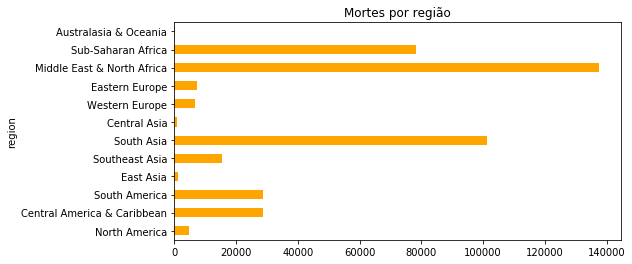

In [8]:
region_kill_pvt = terrorism.pivot_table(values='nkill', index='region', aggfunc=np.sum)
region_kill_pvt.rename({1: 'North America', 2: 'Central America & Caribbean', 3: 'South America', 4:'East Asia', 5:'Southeast Asia', 6:'South Asia', 7:'Central Asia', 8:'Western Europe', 9:'Eastern Europe', 10:'Middle East & North Africa', 11: 'Sub-Saharan Africa', 12:'Australasia & Oceania'}, inplace=True)
region_kill_pvt.plot(kind = 'barh', title = 'Mortes por região', legend = False, figsize =(8, 4), color = 'orange')

However, we can suppose that the distribution and characteristics of terrorism attacks have changed sharply over the years. Afterall, 09/11 was both a consequence and an igniter of drastic modifications!

In [9]:

terror_modern = terrorism[terrorism['iyear'] > 2000]
terror_old = terrorism[terrorism['iyear'] <= 2000]

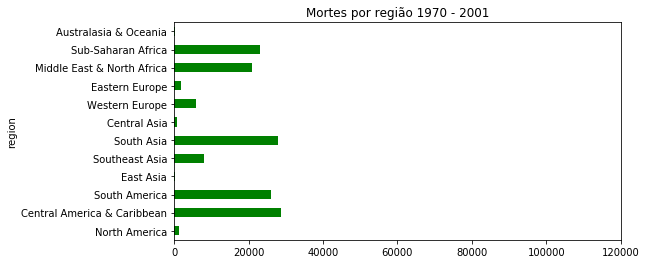

In [10]:
region_kill_pvt_old = terror_old.pivot_table(values='nkill', index='region', aggfunc=np.sum)
region_kill_pvt_old.rename({1: 'North America', 2: 'Central America & Caribbean', 3: 'South America', 4:'East Asia', 5:'Southeast Asia', 6:'South Asia', 7:'Central Asia', 8:'Western Europe', 9:'Eastern Europe', 10:'Middle East & North Africa', 11: 'Sub-Saharan Africa', 12:'Australasia & Oceania'}, inplace=True)
region_kill_pvt_old.plot(kind = 'barh', title = 'Mortes por região 1970 - 2001', legend = False, figsize =(8, 4), color = 'green', xlim = (0,120000))

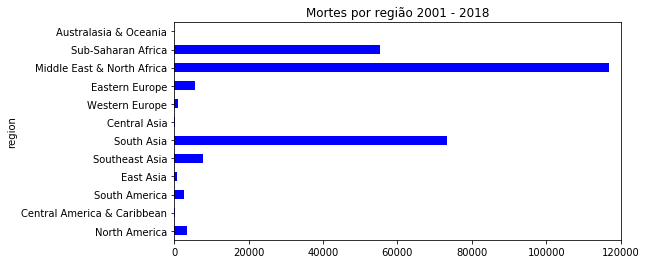

In [11]:
region_kill_pvt_modern = terror_modern.pivot_table(values='nkill', index='region', aggfunc=np.sum)
region_kill_pvt_modern.rename({1: 'North America', 2: 'Central America & Caribbean', 3: 'South America', 4:'East Asia', 5:'Southeast Asia', 6:'South Asia', 7:'Central Asia', 8:'Western Europe', 9:'Eastern Europe', 10:'Middle East & North Africa', 11: 'Sub-Saharan Africa', 12:'Australasia & Oceania'}, inplace=True)
region_kill_pvt_modern.plot(kind = 'barh', title = 'Mortes por região 2001 - 2018', legend = False, figsize =(8, 4), color = 'blue', xlim = (0,120000))

### Period selection

It can be seen, therefore, that there is a clear imbalance between regions. It is also easily noticeable that the year 2001 is a good milestone to demonstrate a change in the profile of terrorist acts, which start to generate, in a shorter period, a substantially higher total number of deaths.

Therefore, from now on, we will work with a dataset composed exclusively of attacks that occurred in the period after 2001.    

### Narrowing the group list

Right now, we can take into account another tiny issue. Even when we narrow the time period, there are too many terrorist groups:

In [12]:
terror_modern['gname'].unique().shape

(1429,)

Worse than that, the number of attacks are very unbalanced, with plenty of gorups with insignificant apperances:

In [13]:
groups_counts = terror_modern['gname'].value_counts()
groups_counts

Unknown                                                                                               57689
Taliban                                                                                                7474
Islamic State of Iraq and the Levant (ISIL)                                                            5613
Al-Shabaab                                                                                             3288
Boko Haram                                                                                             2418
Communist Party of India - Maoist (CPI-Maoist)                                                         1878
New People's Army (NPA)                                                                                1778
Maoists                                                                                                1607
Tehrik-i-Taliban Pakistan (TTP)                                                                        1351
Kurdistan Workers' Party (PK

In [14]:
groups_counts_significant = groups_counts.where(groups_counts >= 20).dropna()

In [15]:
print(groups_counts_significant.shape)
groups_counts_significant

(202,)


Unknown                                                         57689.0
Taliban                                                          7474.0
Islamic State of Iraq and the Levant (ISIL)                      5613.0
Al-Shabaab                                                       3288.0
Boko Haram                                                       2418.0
Communist Party of India - Maoist (CPI-Maoist)                   1878.0
New People's Army (NPA)                                          1778.0
Maoists                                                          1607.0
Tehrik-i-Taliban Pakistan (TTP)                                  1351.0
Kurdistan Workers' Party (PKK)                                   1234.0
Revolutionary Armed Forces of Colombia (FARC)                    1171.0
Houthi extremists (Ansar Allah)                                  1062.0
Al-Qaida in the Arabian Peninsula (AQAP)                         1020.0
Al-Qaida in Iraq                                                

In [16]:
groups_counts_insignificant = groups_counts.mask(groups_counts >= 20).dropna()

In [17]:
print(groups_counts_insignificant.shape)
groups_counts_insignificant

(1227,)


Mahdi Army                                                                                            19.0
Mapuche activists                                                                                     19.0
Rebels                                                                                                19.0
Shura Council of Benghazi Revolutionaries                                                             19.0
Pro-Russia Militia                                                                                    19.0
Supporters of Abd Rabbuh Mansur Hadi                                                                  19.0
Gbagbo Loyalists                                                                                      18.0
Young Communist League                                                                                18.0
Anti-Abortion extremists                                                                              18.0
Mujahideen Ansar                     

In [18]:
sum_insignificant = groups_counts_insignificant.sum()
sum_insignificant

3961.0

In [19]:
sum_significant = groups_counts_significant.sum()
sum_significant

106080.0

In [20]:
sum_total = groups_counts.sum()
sum_total

110041

Thus, we can verify that despite existing 1429 terrorist groups in the dataset, 85% of these are very little representative, with less than an average of one attack per year in the last 20 years and represents just 3,5% of the total attacks.
In this sense, for the sake of avoiding noise, we can strip these less frequent groups.


### Unkown cases

Another relevant issue is the large proportion (52%) of unknown responsible for the terrorist attacks. They are not useful as information for our supervised machine learning algorithm. As above mentioned, we segregate these entries, and train our model exclusively with known subjects. Once the model is trained, we use it to try to figure possible perpetrators among the known groups. Finally, we use K-Means to cluster hard to predict cases. 

### Columns Missing too much data

Text(0.5, 1.0, 'Proportion of Nan by Column')

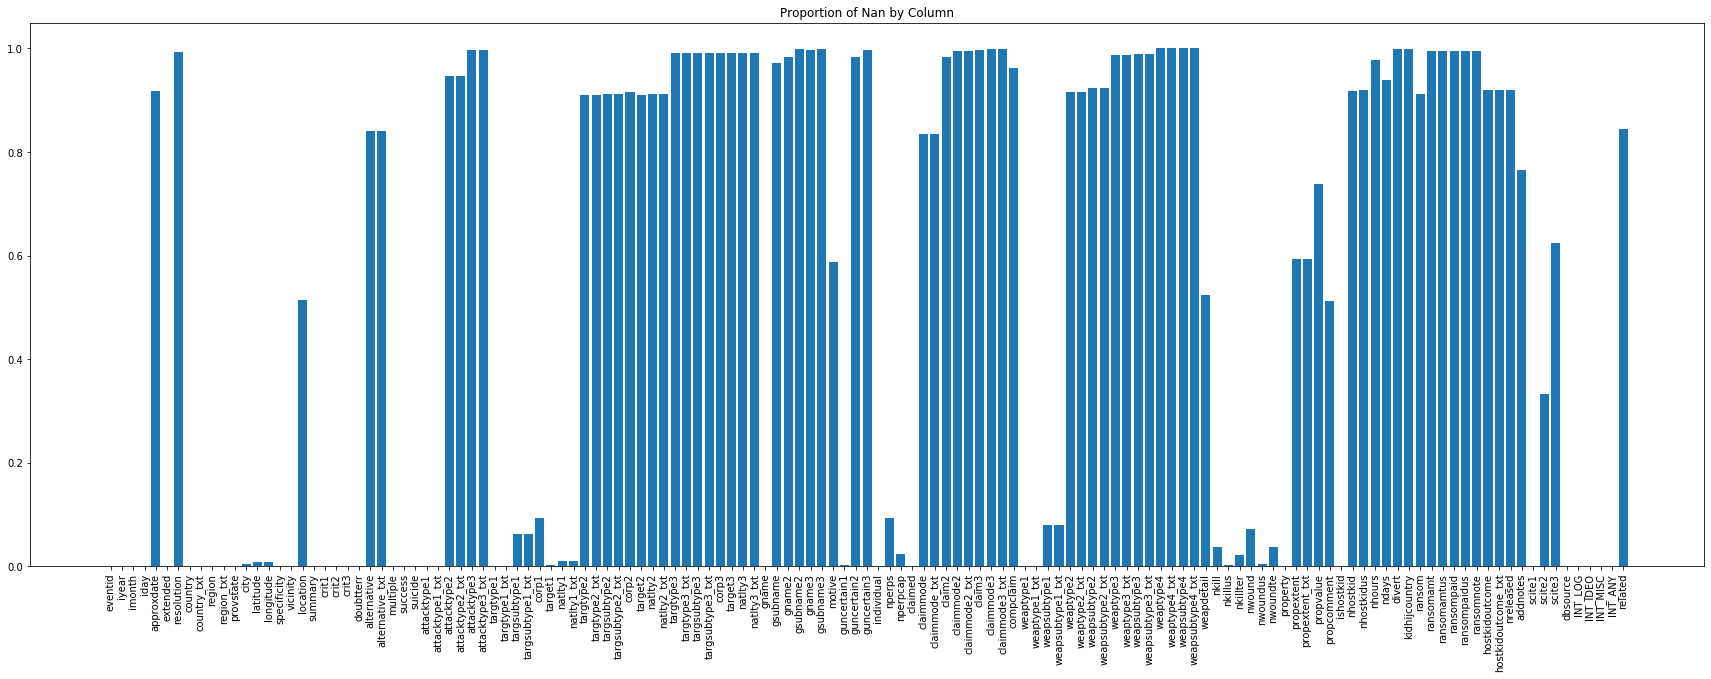

In [21]:
cols = []
n_nan =[]
many_nan = []
for col in terror_modern.columns:
    nan_proportion = terror_modern[terror_modern[col].isna()].shape[0]/terror_modern.shape[0]
    n_nan.append(nan_proportion)
    cols.append(col)
    if nan_proportion > 0.2:
        many_nan.append(col)

plt.figure(figsize = (30,10))
plt.xticks(rotation=90)
plt.bar(cols, n_nan)
plt.title('Proportion of Nan by Column')

As we can see, there are many columns with too much missing data. In our data cleaning steps, we are going to rip off all the columns with more than 20% missing data. The remaining missing data will be replaced by the median, if the column is numeric, and by 'missing value', if categorical.

Another issue in this data there are many text categorical columns with excessive unique values. These columns are much more descriptive than categorical and can bring more noise than useful information to the model.

### Classification of Columns

We use the aforementioned codebook to 'manually' build a classification of the columns as follows:

**cols_to_drop -** columns that we can infer that have no use to the machine learning algorithm. Are inserted in this group columns that are time related (we do not use time series), columns that bring duplicated information, usually text describing already categorized information, text columns that are too specific, some subclassifications, categories with limited application (for example, just applicable for one kind of attack)or with no predictive value like source of information.

**categorical_cols -** columns that represent categories and, thus, must be encoded as dummy variables. Some in this set represent a challenge, since, if the unique values are excessive, it is probable that do not capture enough generalization, and, at the same time, will demand creation of too many columns in the preparation of the dataset, with large computational costs. In this sense, in the data cleaning process we will rip off columns with mora than 1000 categories.

**numeric_cols -** These are self-explanatory

## D) Data cleaning 

Now we start the data cleaning process.

It will not be an easy path. As we already mentioned, there are plenty of missing values, categorical columns with excessive unique values, hundreds of columns have to be created in order to encode categories as dummies, and, most relevant of all, we have to assure that we can fit new data in the same format of the training one.
The best way we found to do so is to create a set of functions and use a pipeline to concatenate these steps.

The cleaning function will have a double use. It can be settled to start de cleaning process of the data set, or, alternately, to fit a specific data in the format of the trained one.

First, let's classify the columns:

In [22]:
cols_to_drop = ['iyear', 'imonth', 'iday', 'approxdate', 'resolution', 'summary', 'alternative_txt', 'related', 'country_txt','region_txt', 'vicinity', 'location', 'latitude', 'longitude', 'specificity', 'attacktype1_txt', 'attacktype2_txt', 'attacktype3_txt', 'weaptype1_txt','weaptype2_txt', 'weaptype3_txt', 'weaptype4_txt', 'weapsubtype1_txt', 'weapsubtype2_txt', 'weapsubtype3_txt', 'weapsubtype4_txt', 'weapdetail', 'targtype1_txt', 'targtype2_txt', 'targtype3_txt', 'targsubtype1_txt', 'targsubtype2_txt', 'targsubtype3_txt', 'scite1', 'scite2', 'scite3', 'dbsource', 'corp1', 'corp2', 'corp3', 'target1', 'target2', 'target3', 'natlty1_txt','natlty2_txt', 'natlty3_txt', 'gsubname', 'gsubname2','gsubname3', 'guncertain1', 'guncertain1', 'guncertain3', 'claimmode_txt', 'claim2', 'claimmode2', 'claimmode2_txt', 'claim3', 'claimmode3', 'claimmode3_txt', 'motive', 'propextent_txt', 'propvalue', 'propcomment', 'nhours', 'ndays', 'nhostkid', 'nhostkidus', 'divert', 'kidhijcountry', 'ransom', 'ransomamt', 'ransomamtus', 'ransompaid', 'ransompaidus', 'ransomnote', 'hostkidoutcome', 'hostkidoutcome_txt', 'nreleased', 'addnotes']
categorical_cols = ['extended', 'crit1', 'crit2', 'crit3','doubtterr', 'alternative', 'multiple', 'country', 'region', 'provstate', 'city', 'attacktype1', 'attacktype2', 'attacktype3', 'success', 'suicide', 'weaptype1', 'weaptype2', 'weaptype3', 'weaptype4','weapsubtype1', 'weapsubtype2', 'weapsubtype3', 'weapsubtype4','targtype1','targtype2', 'targtype3', 'targsubtype1', 'targsubtype2','targsubtype3', 'natlty1','natlty2', 'natlty3', 'gname', 'gname2', 'gname3', 'individual', 'claimed', 'claimmode', 'compclaim', 'property', 'ishostkid', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY'] 
numeric_cols = ['nperps', 'nperpcap', 'nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte']

**Step by step - Data cleaning of the training and test sets:**

1) Here we are just using the id of the attack as index:

In [23]:
def set_index_id (data):
    data.set_index('eventid', inplace = True)

2) Here, as already explained, we make a selection o time period, restricting the dateset for attacks that occuried from 2001 to now.

In [24]:
def restrict_modern_time(data):
    return data[data['iyear'] > 2000]

3) Now we eliminate attacks of groups with minimal representation (less than 20 attacks in the last 20 years)

In [25]:
def frequent_goups(data):    
    cases_by_group = data['gname'].value_counts()
    frequent_groups_name = list(cases_by_group[cases_by_group >= 20].index)
    return data[data['gname'].isin(frequent_groups_name)]

4) As mentioned, it is possible, from the codebook, to identify the columns that have restricted use to the predictive model. so, we drop all the columns here.

In [26]:
def drop_col_non_model(data):
    data.drop(cols_to_drop, axis =1, inplace = True)

5) Here we segregate the attacks with unknown perpetrators. We will, later, use the predictive model to try to associate the attacks with known terrorist groups or cluster the ones predicted low level of security.

In [27]:
def drop_gname_unknown(data):
    gname_unknown = data[ data['gname'] == 'Unknown']
    data.drop(gname_unknown.index, axis = 0, inplace = True)

6) Now, we build a function that drops all columns with more than 20% of missing values.As explained, we understand that these ones brig more noise than information.

In [28]:
def drop_col_full_of_na (data):
    drop_col_full_of_na_droped = []
    for col in data.columns:
        if data[data[col].isna()].shape[0]/data.shape[0] > 0.2:
            drop_col_full_of_na_droped.append(col)
            data.drop(col, axis = 1, inplace = True)
            if col in categorical_cols:
                categorical_cols.remove(col)
            if col in numeric_cols:
                numeric_cols.remove(col)
    for col in data.columns:
        if data[(data[col] == -9)|(data[col] == -99)].shape[0]/data.shape[0] > 0.2:
                drop_col_full_of_na_droped.append(col)
                data.drop(col, axis = 1, inplace = True)
                if col in categorical_cols:
                    categorical_cols.remove(col)
                if col in numeric_cols:
                    numeric_cols.remove(col)

7) Here, we drop categorical columns with more than 1000 unique values. We understand that there is a lack of generalization in these columns and it causes noise to the model.

In [29]:
def drop_cat_many_unique (data):
    for col in data[categorical_cols].columns:
        uni = data[col].unique().shape[0]    
        if uni > 1000:
            data.drop(col, axis = 1, inplace = True)
            if col in categorical_cols:
                categorical_cols.remove(col)
            if col in numeric_cols:
                numeric_cols.remove(col)

8) Now we replace missing values from the numeric columns of the training dataset by its median.

In [30]:
def imputer_numeric (data):
    imp_numeric = SimpleImputer(strategy= 'median')
    imp_numeric.fit(data[numeric_cols])
    return imp_numeric.transform(data[numeric_cols])

9) There are some -9 and -99 in the data set that also represent missing values. So, we also replace then with the median when in the numeric columns.

In [31]:
def numeric_9_99 (data):
    for col in data[numeric_cols].columns:
        data[col].replace({-99: data[col].median()}, inplace = True)
        data[col].replace({-9: data[col].median()}, inplace = True)


10) When the missing values are in the categorical columns, we replace then by 'missing values'.

In [32]:
def imputer_cat(data):

    imp_cat = SimpleImputer(strategy= 'constant')
    imp_cat.fit(data[categorical_cols])
    return imp_cat.transform(data[categorical_cols])

def cat_9_99 (data):
    for col in data[numeric_cols].columns:
        data[col].replace({-99: 'missing_value'}, inplace = True)
        data[col].replace({-9: 'missing_value'}, inplace = True)

11) After that we encode the name of terrorist groups in a numerical form.

In [33]:
def labeling_gname(data):
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(data['gname']), label_encoder

12) The we segregate the column with the perpetrator as Y, and the remaining as X

In [34]:
def segregate_gname (data):
    Y = data['gname']
    data = data.drop('gname', axis = 1, inplace = True)
    categorical_cols.remove('gname')
    return Y

13) Here we build new columns, transforming categorical columns in a group of dummy columns.

In [35]:
def dumming (data):
    X = pd.get_dummies(data, columns = categorical_cols, drop_first = True)
    return X

14) Some categorical columns have numbers in mixed data types (float, int), this may cause some confusions, when fitting new data to the same format. So we will use string methods to modify the column names, striping '.0'.

15) Now we are ready. We, can split between test and train:

In [36]:
def train_test(X, Y):
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.20, random_state=51)
    return x_train, x_test, y_train, y_test

Here we just leave a pratical function to help to save the data in some steps:

In [37]:
def saving_for_comp(data):
    return data

**Data cleaning of new data-sets, object of trained predition model:**

The main difference in the data cleaning process is that the new data must fit the format of the trained data. In this sense:

1) Set the index with the id of the attack

2) Restrict to the attacks from 2001 to the present (function already created)

3) Exclude all columns that were not present in training data set (before the creations of dummies)

4) Build a new function, that fill missing numerical values with the median values of the respective columns of the trained data: 

In [38]:
def fill_unknown(data_pre, data):
    
    for col in data_pre[numeric_cols].columns:
        
        data_pre[col].fillna(data[col].median(), inplace = True)
            
        if -99 in data_pre[col].values:
            
            data_pre[col].replace({ -99 : data[col].median()}, inplace = True)
            
        if -9 in data_pre[col].values:
            
            data_pre[col].replace({ -9 : data[col].median()}, inplace = True)

5) Replace missing values (NaN, -9, -99) of the categorical columns with 'missing value'. (functions already created)

6) Build dummy columns. (function already created)

7) As before explained, we use string methods to strip '.0'from name of the columns, in order to avoid differ columns that should be the same.

8) If there is any column in the trained data set that is not present in this one, we include a new column (dummy) and equal all values to 0 (this category is not present in this dataset.)

9) If there is any columns in the new data (dummy) that is not present in the trained data, we drop that columns, and drop all entries with that characteristic (dummy =1)

10) Finally, we reorder the columns, so as to make sure they follow the same sequence of the trained data.

Now, we can make sure that the new data is in the same format of the trained one. 

We build a function that concatenate all these steps. By default, the function will just return x_train, x_test, y_train, y_test. It can also be settled to clean a new dataset in the same format, and it will return the cleaned data, with also a label encoder parameter that will be useful in the future to reverse predicted number values to the actual name of the terrorists groups. 

In [57]:
def cleaning(dataset_base, predict = False, dataset_pre_base = None):
       
    
    dataset = dataset_base.copy()
    
    set_index_id(dataset)
        
    dataset = restrict_modern_time(dataset)
    
    dataset = frequent_goups(dataset)
        
    drop_col_non_model(dataset)
        
    drop_gname_unknown(dataset)
            
    drop_col_full_of_na (dataset)
    
    drop_cat_many_unique (dataset)

    dataset[numeric_cols] = imputer_numeric (dataset)
    
    numeric_9_99 (dataset)
    
    dataset[categorical_cols] = imputer_cat (dataset)
    
    cat_9_99 (dataset)
    
    original_reference = saving_for_comp(dataset)
    
    dataset['gname'], label_encoder  = labeling_gname(dataset)

    Y = segregate_gname (dataset)
        
    X = dumming (dataset)
    
    new_cols= {}
    
    for col in X.columns:

        col2 = col.split('.')[0]
        new_cols[col] = col2

    X.rename(columns = new_cols, inplace = True)
    
    x_train, x_test, y_train, y_test = train_test(X, Y)
    
    if predict == False:
        
        return x_train, x_test, y_train, y_test

    if predict == True:
        
        dataset_pre = dataset_pre_base.copy()
        
        original_col_set =  list(original_reference.columns)
        
        set_index_id(dataset_pre)
        
        dataset_pre = restrict_modern_time(dataset_pre)
        
        dataset_pre = dataset_pre[original_col_set]
        
        fill_unknown(dataset_pre, dataset)
        
        dataset_pre[categorical_cols] = imputer_cat (dataset_pre)
        
        cat_9_99 (dataset_pre)
        
        dataset_pre = pd.get_dummies(dataset_pre, columns = categorical_cols, drop_first = True)
        
        new_cols_pre = {}
        
        for col in dataset_pre.columns:

            col2 = col.split('.')[0]
            new_cols_pre[col] = col2

            dataset_pre.rename(columns = new_cols_pre, inplace = True)
        
        for col in X.columns:
            
            if col not in dataset_pre.columns:
    
                dataset_pre[col] = 0
            
        brand_new_cols  = []
        
        for col in dataset_pre.columns:
            
            if col not in X.columns:
                
                brand_new_cols.append(col)
            
        
        for col in brand_new_cols:
            
            dataset_pre.drop(dataset_pre[dataset_pre[col] == 1].index, axis = 0, inplace = True)
            dataset_pre.drop(col, axis = 1, inplace = True)
            
        
        
        dataset_pre = dataset_pre.reindex(columns = X.columns)
        
        return  dataset_pre, label_encoder
        

Let's use this function to clean our data and get x_train, x_test, y_train, y_test:

In [40]:
x_train, x_test, y_train, y_test = cleaning(terrorism)

In [41]:
x_train.head()

nperpcap  nkill  nkillus  nkillter  nwound  nwoundus  nwoundte  \
eventid                                                                        
201502260004       0.0    0.0      0.0       0.0     0.0       0.0       0.0   
201203240013       0.0    6.0      0.0       3.0     0.0       0.0       0.0   
201309130008       0.0    1.0      0.0       1.0    18.0       0.0       0.0   
201707050003       0.0    3.0      0.0       2.0     0.0       0.0       0.0   
201709250010       0.0    0.0      0.0       0.0     0.0       0.0       0.0   

              extended_1  crit1_1  crit2_1  crit3_1  doubtterr_1  multiple_1  \
eventid                                                                        
201502260004           0        1        1        0            1           0   
201203240013           0        1        1        1            0           0   
201309130008           0        1        1        1            0           0   
201707050003           0        1        1        1            0           1   
201709250010           1        1        1        1            0           0   

              multiple_missing_value  country_5  country_6  country_8  \
eventid                                                                 
201502260004                       0          0          0          0   
201203240013                       0          0          0          0   
201309130008                       0          0          0          0   
201707050003                       0          0          0          0   
201709250010                       0          0          0          0   

              country_11  country_14  country_15  country_16  country_18  \
eventid                                                                    
201502260004           0           0           0           0           0   
201203240013           0           0           0           0           0   
201309130008           0           0           0           0           0   
201707050003           0           0           0           0           0   
201709250010           0           0           0           0           0   

              country_19  country_21  country_25  country_28  country_32  \
eventid                                                                    
201502260004           0           0           0           0           0   
201203240013           0           0           0           0           0   
201309130008           0           0           0           0           0   
201707050003           0           0           0           0           0   
201709250010           0           0           0           0           0   

              country_33  country_34  country_36  country_37  country_38  \
eventid                                                                    
201502260004           0           0           0           0           0   
201203240013           0           0           0           0           0   
201309130008           0           0           0           0           0   
201707050003           0           0           0           0           0   
201709250010           0           0           0           0           0   

              country_41  country_42  country_43  country_44  country_45  \
eventid                                                                    
201502260004           0           0           0           0           0   
201203240013           0           0           0           0           0   
201309130008           0           0           0           0           0   
201707050003           0           0           0           0           0   
201709250010           0           0           0           0           0   

              country_47  country_49  country_54  country_55  country_56  \
eventid                                                                    
201502260004           0           0           0           0           0   
201203240013        

In [42]:
x_train.shape

(38712, 478)

In [43]:
y_train.shape

(38712,)

In [44]:
x_test.shape

(9679, 478)

In [45]:
y_test.shape

(9679,)

It worked well. it seems that we have data in the correct format.
We can also note a drastic change. The dataset was naturally reduced, we dropped many columns and created new ones (dummies).
Now we can start building the model.

## D) Model

We start with a random forest classifier algorithm.

Here we use a randomized grid search to find the points of proximity to the best hyperparameters.

#### Fine tuning

In [46]:
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high= 480),'max_depth' :randint(low=1, high= 50)}

forest_class = RandomForestClassifier(random_state=51)
rnd_search = RandomizedSearchCV(forest_class, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='accuracy', random_state=51)
rnd_search.fit(x_train, y_train)
rnd_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=31, max_features=29,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=85,
                       n_jobs=None, oob_score=False, random_state=51, verbose=0,
                       warm_start=False)

Now we search the best hyperparameters ranging around the parametrs found in the randomized search.

In [47]:
param_grid = [{'n_estimators': list(range(60,120,10)), 'max_depth': list(range(20,45,5)), 'max_features' : list(range(20,40,5))}]

grid_search = GridSearchCV(forest_class, param_grid, cv=5,scoring= 'accuracy', return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'max_depth': 30, 'max_features': 35, 'n_estimators': 110}

In [48]:
grid_search.best_score_

0.8460940662465507

Once we found the right hyperparameters, we train our model.

#### Modeling

In [49]:
forest_class_final = RandomForestClassifier(max_depth= 30, max_features= 35, n_estimators =60, random_state=51)
forest_class_final.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features=35,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=51, verbose=0,
                       warm_start=False)

Here we test the results with cross validation.

#### Scores

In [50]:
from sklearn.model_selection import cross_val_score
forest_scores = cross_val_score(forest_class_final, x_train, y_train,
                                scoring = "accuracy", cv=10)
forest_scores

array([0.85356405, 0.84969008, 0.84913459, 0.84603462, 0.83931801,
       0.84706794, 0.84784293, 0.84138466, 0.84887626, 0.84112632])

We can see that we have a very reasonable result. With almost 85% of accuracy.

As baseline, we build a simple method: predict the mode for all cases.

In [52]:
y_train_mode = int(y_train.mode().values)
dumb_method_score = y_train[y_train == y_train_mode].shape[0]/y_train.shape[0]
dumb_method_score

0.15364744781979747

We can see that our model has more than 5 times the accuracy of the baseline.

Let's take a look in the confusion matrix.

In [68]:
y_train_pred = forest_class_final.predict(x_train)

In [69]:
c_m = confusion_matrix(y_train, y_train_pred)

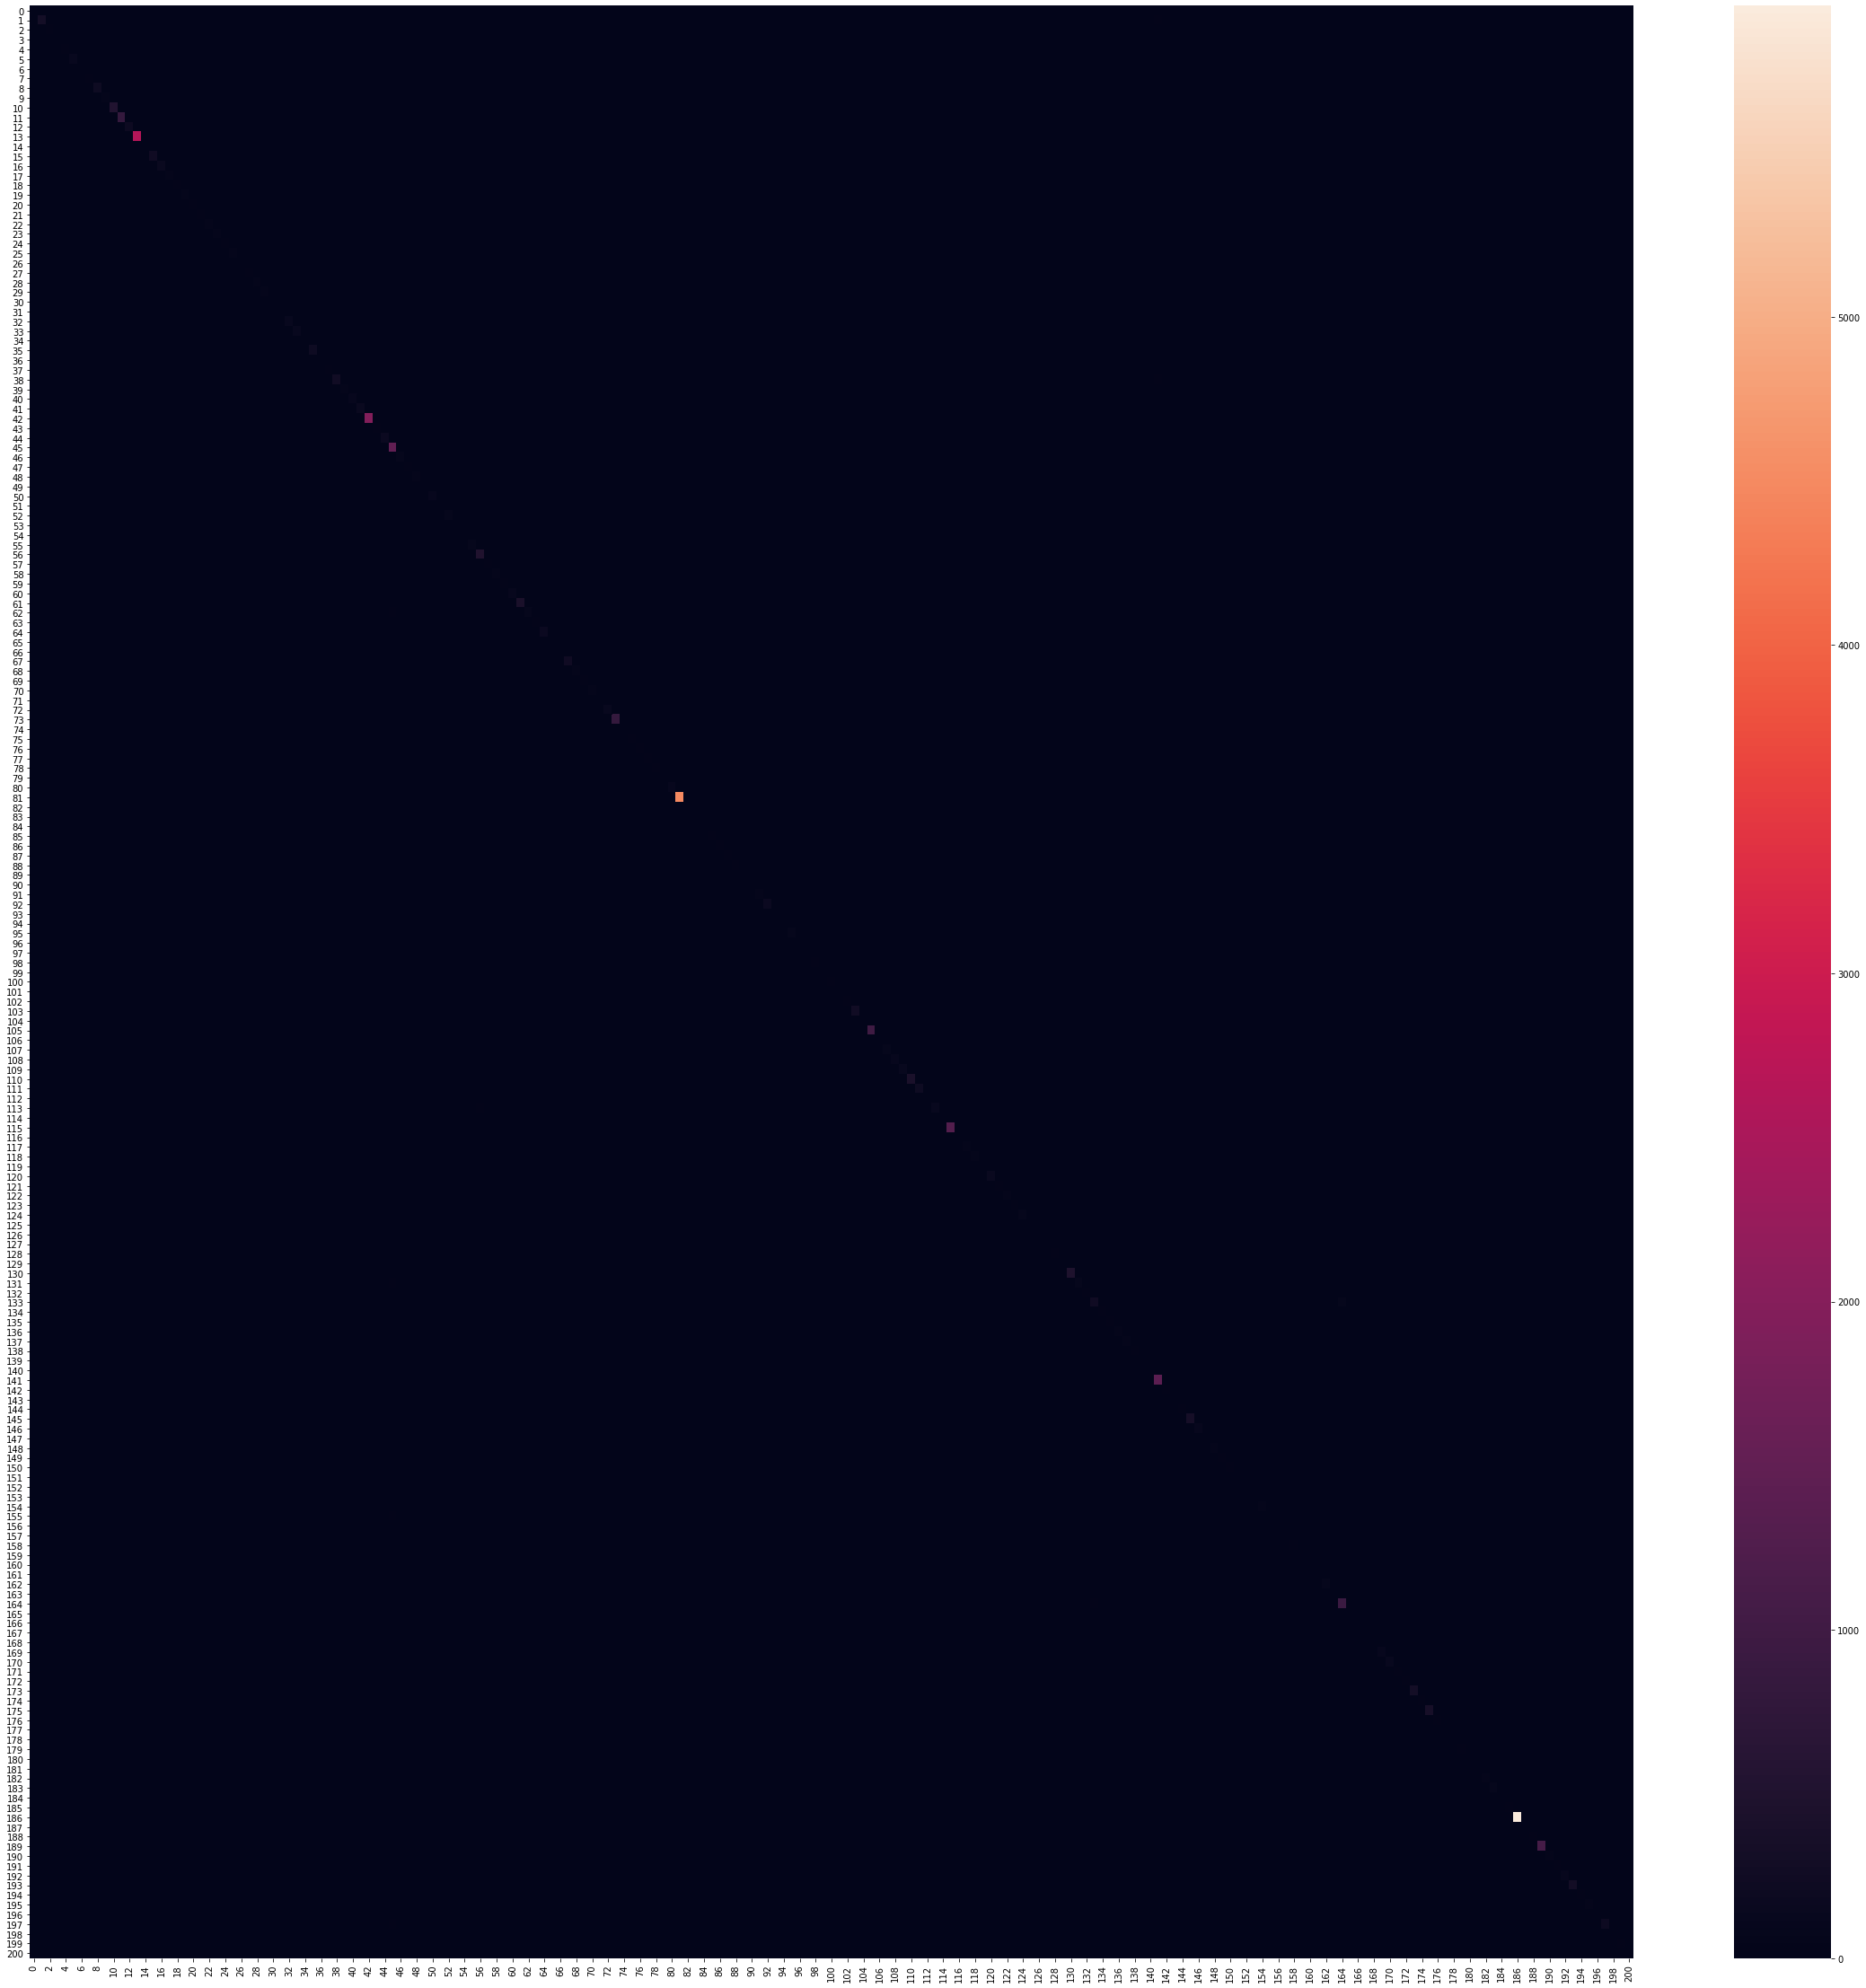

In [89]:
fig, ax = plt.subplots(figsize=(40,40)) 
sns.heatmap(c_m, annot=False)

We can see that there is a high concentration of predictions. At the same time, no recurring error can be distinguished in absolute numbers. All the clear points are on the diagonals, representing correct predictions.

Now we take a look at the relevance of features:

In [113]:
importances= forest_class_final.feature_importances_

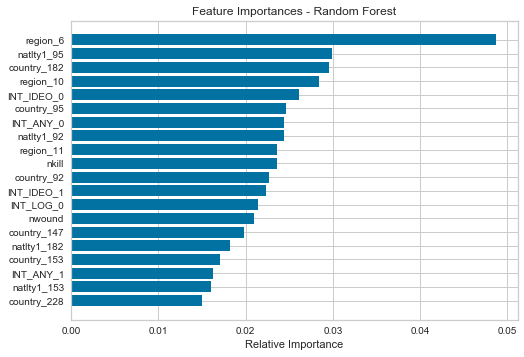

In [122]:
features = x_train.columns
indices = np.argsort(importances)[-20:]

plt.title('Feature Importances - Random Forest')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We can see that there is a large distribution among the relevant features, with the most important one representing only 5%. Of course, this is largely due to the breakdown of dummy variables in the same category.

In this sense, 9 out of the 20 best parameters are related to the location of the event. In particular the overriding factor and the column that represents the fact that the event took place in South Asia.

Here we bring the meaning of the first 10 variables:

1) Event took place in South Asia.

2) If the victim is Iraqi

3) If the attack occurred in Somalia

4) If the event took place in the Middle East or North Africa

5) If the victim has a nationality different from the terrorist

6) If the event took place in Iraq

7) If the attack was international in any dimension

8) If the event took place in India

9) If the event took place in sub-Saharan Africa

10) Number of deaths in the attack.

#### Final Scores

In [53]:
final_predictions = forest_class_final.predict(x_test)

final_accuracy_score = accuracy_score(y_test, final_predictions)

final_accuracy_score

0.8454385783655336

**The final scores, using the test set, is very similar - next to 85%.**

## E) Tackling the Unknown Dataset

So, we, have trained the model. Now we are going to use it. 

First we segregate the unknown group:

In [54]:
unknown = terrorism[terrorism['gname'] == 'Unknown']

Now we clean it, using our created function:

In [58]:
cols_to_drop = ['iyear', 'imonth', 'iday', 'approxdate', 'resolution', 'summary', 'alternative_txt', 'related', 'country_txt','region_txt', 'vicinity', 'location', 'latitude', 'longitude', 'specificity', 'attacktype1_txt', 'attacktype2_txt', 'attacktype3_txt', 'weaptype1_txt','weaptype2_txt', 'weaptype3_txt', 'weaptype4_txt', 'weapsubtype1_txt', 'weapsubtype2_txt', 'weapsubtype3_txt', 'weapsubtype4_txt', 'weapdetail', 'targtype1_txt', 'targtype2_txt', 'targtype3_txt', 'targsubtype1_txt', 'targsubtype2_txt', 'targsubtype3_txt', 'scite1', 'scite2', 'scite3', 'dbsource', 'corp1', 'corp2', 'corp3', 'target1', 'target2', 'target3', 'natlty1_txt','natlty2_txt', 'natlty3_txt', 'gsubname', 'gsubname2','gsubname3', 'guncertain1', 'guncertain1', 'guncertain3', 'claimmode_txt', 'claim2', 'claimmode2', 'claimmode2_txt', 'claim3', 'claimmode3', 'claimmode3_txt', 'motive', 'propextent_txt', 'propvalue', 'propcomment', 'nhours', 'ndays', 'nhostkid', 'nhostkidus', 'divert', 'kidhijcountry', 'ransom', 'ransomamt', 'ransomamtus', 'ransompaid', 'ransompaidus', 'ransomnote', 'hostkidoutcome', 'hostkidoutcome_txt', 'nreleased', 'addnotes']
categorical_cols = ['extended', 'crit1', 'crit2', 'crit3','doubtterr', 'alternative', 'multiple', 'country', 'region', 'provstate', 'city', 'attacktype1', 'attacktype2', 'attacktype3', 'success', 'suicide', 'weaptype1', 'weaptype2', 'weaptype3', 'weaptype4','weapsubtype1', 'weapsubtype2', 'weapsubtype3', 'weapsubtype4','targtype1','targtype2', 'targtype3', 'targsubtype1', 'targsubtype2','targsubtype3', 'natlty1','natlty2', 'natlty3', 'gname', 'gname2', 'gname3', 'individual', 'claimed', 'claimmode', 'compclaim', 'property', 'ishostkid', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY'] 
numeric_cols = ['nperps', 'nperpcap', 'nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte']

In [59]:
dataset_pre, label_encoder  = cleaning(terrorism, predict = True, dataset_pre_base = unknown)

In [60]:
dataset_pre.shape

(53156, 478)

We have a prepared dataset to aply our predictive model.

### Capturing uncertainty

Despite having a predictive classifier model, it is very useful not just to know which is the predictions, but also, a range of best options, especially if the level of certainty is not very high.
So, we build a function that identify the level of certainty of the prediction, and, for a threshold, return a dictionary with a range of possible perpetrators and the respective probability for each attack

In [61]:
def tree_test_doubts(tree_model, label_encoder, data,  prob_limit_inferior, prob_limit_superior):

    dic_total= {}
    for i, j in data.iterrows():
        j = np.array(j)
        j = j.reshape(1,-1)
        prob_array = tree_model.predict_proba(j)
        if np.max(prob_array) < prob_limit_superior:
            indec_elements = list(prob_array[(prob_array > prob_limit_inferior) & (prob_array < prob_limit_superior)])
            if len(indec_elements) != 0:
                groups_numb_list = list(np.where((prob_array > prob_limit_inferior) & (prob_array < prob_limit_superior)))[1]
                groups_name_list = label_encoder.inverse_transform(groups_numb_list)
                dic_entry = {}
                for a in range(len(groups_name_list)):
                    dic_entry[groups_name_list[a]] = indec_elements[a]
                dic_total[i] = dic_entry

        
    return dic_total

Given that the distribution of attacks is very concentrated among terrorist groups, and, considering the existence of general categories of groups, there is a tendency for the prediction to be concentrated among the most general occurrences for certain characteristics. 

In [63]:
predic_unknown = forest_class_final.predict(dataset_pre)
predic_unknown_names = label_encoder.inverse_transform(predic_unknown)
predic_unknown_names_s = pd.Series(predic_unknown_names)
predic_unknown_names_s.value_counts()

Muslim extremists                                             25069
Gunmen                                                         8249
Militants                                                      5210
Maoists                                                        3157
Separatists                                                    2955
Sunni Muslim extremists                                        2102
Tribesmen                                                      2087
Fulani extremists                                               964
Taliban                                                         866
Anarchists                                                      703
Anti-Muslim extremists                                          385
Muslim Separatists                                              313
Dissident Republicans                                           227
Al-Shabaab                                                      187
The New Irish Republican Army                   

That's why is so useful to be able to capture a range of possibilities. Now we use test_doubts function to analyze the prediction for the unknown dataframe. We set a minimum level of certainty to 60%.

In [64]:
unknown_uncertain = tree_test_doubts(forest_class_final, label_encoder, dataset_pre, 0.20, 0.60)
unknown_uncertain

{200101010001: {'Muslim extremists': 0.5333333333333333,
  'Tribesmen': 0.36666666666666664},
 200101010004: {'Islamic State of Iraq and the Levant (ISIL)': 0.23333333333333334,
  "Kurdistan Workers' Party (PKK)": 0.21666666666666667,
  'Muslim extremists': 0.39056992465529045},
 200101050002: {'Muslim extremists': 0.31253785192713596},
 200101050004: {'Maoists': 0.3, 'Muslim extremists': 0.2833333333333333},
 200101060004: {'Muslim extremists': 0.5190249185479043},
 200101070002: {'Muslim extremists': 0.3063965912211597},
 200101100003: {'Gunmen': 0.24505276386628358,
  'Muslim extremists': 0.23641424262602148,
  'Revolutionary Armed Forces of Colombia (FARC)': 0.22461920092239243},
 200101100004: {'Gunmen': 0.2092964225152208,
  'Muslim extremists': 0.30629703765485744},
 200101140002: {'Maoists': 0.23243145743145746,
  'Muslim Separatists': 0.2667388167388168,
  'Muslim extremists': 0.3334776334776335},
 200101150001: {'Maoists': 0.4980360884385652},
 200101160006: {'Muslim extremis

And, then, we can segregate those cases with high level of certainty of prediction, from those with low level, building new dataframes:

In [66]:
unknown_uncertain_keys = list(unknown_uncertain.keys())
not_a_clue = dataset_pre.loc[unknown_uncertain_keys, :]
some_certainty = dataset_pre.drop(labels = unknown_uncertain_keys, axis = 0)

Thus, we could have a relative degree of confidence in the predictions made for some_certainty set. Investigations regarding authorship can be initiated to assess whether there is in fact evidence that the predicted group carried out such attacks that, today, are unknown. Such a proposal should be considered especially when there are forecasts for groups with a high degree of specification, and not generic categories.

With regard to the alpha group, although there is a low degree of confidence in the specific forecast, our ability to bring a group of options more likely to these cases already has immense value, being possible to restrict the analysis spectrum.

Additionally, from now on, we will use a beta algorithm, to assess whether there is any pattern among the unknown groups. Based on that, there would be a relevant line of investigation, to assess whether there is the possibility of a single unknown group acting, but acting recurrently.

#### Cluster

We use elbow techinic to estimated the optimal number of clusters.

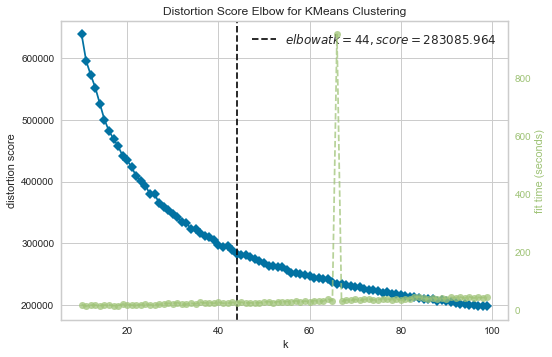

In [100]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(10,100))

visualizer.fit(not_a_clue)        # Fit the data to the visualizer
visualizer.show()  

In [101]:
visualizer.elbow_value_

44

Fitting the model

In [103]:
kmeans = KMeans(n_clusters = 44)
kmeans.fit(not_a_clue)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=44, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

A new column to the dataset indicating the label of the event

In [104]:
not_a_clue_labels = list(kmeans.labels_)

In [105]:
not_a_clue['kluester_label'] = not_a_clue_labels

In [108]:
not_a_clue['kluester_label'].value_counts()

17    4111
1     2995
23    2956
37    2559
28    2150
31    2044
7     1788
33    1785
13    1687
25    1369
10    1243
43    1210
9      693
22     582
34     440
35     318
6      314
4      200
41     169
16     109
24      99
3       61
27      56
11      49
0       38
26      38
2       28
19      18
20      16
40      16
8       15
36      15
12      14
30       6
15       5
21       2
42       2
39       1
29       1
18       1
5        1
14       1
32       1
38       1
Name: kluester_label, dtype: int64

Finally, once we selected groups for which our predictive model has inaccurate predictions, we were able to cluster, bringing together groups with similar characteristics. We have 44 groups, which can be the object of future research, either to look for evidence of groups acting in a systematic way, which are unknown, or to try to create methods of preventing attacks with the same characteristics.

## F) Conclusions

We created a model with significant predictive accuracy. Additionally, we built instruments not only to predict a single and definitive responsible, but also to offer alternative possibilities and respective probabilities. 

These methods can significantly assist investigative work, whether from law enforcement authorities, intelligence agencies or for journalistic work. Repression actions can be taken more quickly, and the verification of false statements of authorship can be improved by using the model created.

Another relevant aspect is that we grouped past attacks of unknown perpetrators, and we tried to make predictions of compatibility with known terrorist groups. For those with low prediction results, we created clusters. In this way, we also brought instruments to support the analysis of past attacks.

On the other hand, there is significant room for improvement:

1) The model tends to make prediction of generic categories.

2) Time-related aspects of attacks are not taken in consideration.

3) In addition to the dataset used, the model would benefit from theoretical studies on the behavior of terrorist groups.

4) Finally, data not related to the attacks themselves, such as socioeconomic condition of the location of the attack or the perpetrator, the occurrence of external or civilian germs in the vicinity, among others, would be essential to a more reliable model.

We intend to develop these aspects in the near future.